In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import tarfile

### Loading Imagenette

In [2]:
# only run once!
with tarfile.open('imagenette2-320.tgz', 'r:gz') as tar:
    tar.extractall(path='.')

In [3]:
path = './imagenette2-320/val/'

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# these values are from the tutorial
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

images = ImageFolder(path, transforms.Compose([transforms.ToTensor(), normalize]))
test_loader = DataLoader(images, batch_size=1, shuffle = True)

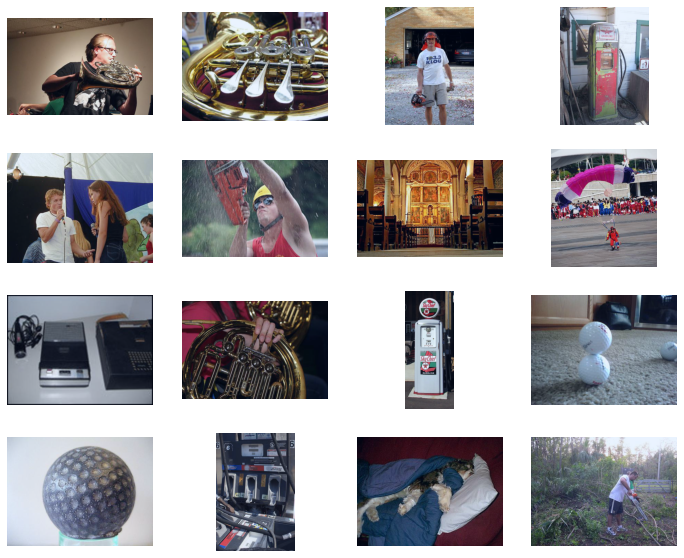

In [5]:
from torchvision.utils import make_grid

# show some images
plt.subplots(figsize=(12, 10))
for i, (images, labels) in enumerate(test_loader):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(make_grid(images[:16], normalize=True).permute(1, 2, 0).clamp(0, 1))
    if i >= 15:
      break

## Fast gradient sign method

Code from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [6]:
import torchvision.models as models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
resnet = models.resnet18(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ezchen2556/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
idxs = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701] # from campuswire #1062

In [11]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [12]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        i = torch.tensor(idxs).to(device)

        output = model(data)[:, i] # only select imagenette classes
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)[:, i] # only select imagenette classes

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [13]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(resnet, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 3071 / 3925 = 0.782420382165605
Epsilon: 0.05	Test Accuracy = 2470 / 3925 = 0.6292993630573248
Epsilon: 0.1	Test Accuracy = 2134 / 3925 = 0.5436942675159235
Epsilon: 0.15	Test Accuracy = 1904 / 3925 = 0.48509554140127387
Epsilon: 0.2	Test Accuracy = 1756 / 3925 = 0.4473885350318471
Epsilon: 0.25	Test Accuracy = 1618 / 3925 = 0.4122292993630573
Epsilon: 0.3	Test Accuracy = 1483 / 3925 = 0.3778343949044586


### Visualizations

Plot of Accuracy vs Epsilon

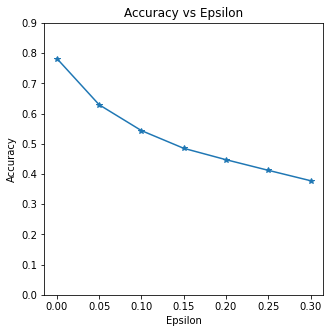

In [14]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Adversarial Samples at Each epsilon

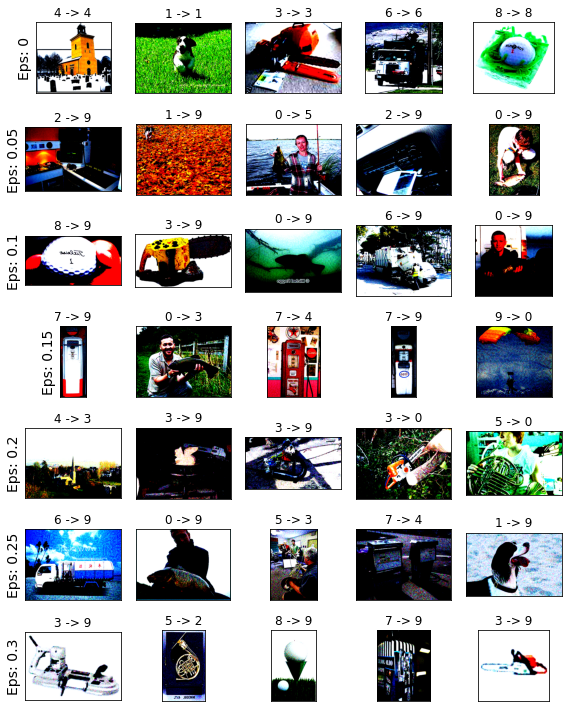

{0: 'tench', 1: 'english Springer', 2: 'cassette player', 3: 'chainsaw', 4: 'church', 5: 'French horn', 6: 'garbage truck', 7: 'gas pump', 8: 'golf ball', 9: 'parachute'}


In [19]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))

        tr = scipy.ndimage.rotate(ex.T, 270) # had to transpose to fit dimensions
        plt.imshow(make_grid(torch.tensor(tr), normalize=True))
plt.tight_layout()
plt.show()
print(label_map)

## Iterative Gradient Sign Method

https://arxiv.org/pdf/1607.02533.pdf

In [31]:
def i_fgsm_attack(image, image_original, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    # clipping
    delta = torch.clamp(perturbed_image - image_original, min=-epsilon, max=epsilon)
    perturbed_image = torch.clamp(image_original + delta, min=0, max=1).detach()
    return perturbed_image

In [34]:
def iterative_test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    iters = int(min(epsilon + 4, 1.25 * epsilon)) # from paper, also alpha=1

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        i = torch.tensor(idxs).to(device)

        output = model(data)[:, i] # only select imagenette classes
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue
        
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        
        data_copy = data.clone().detach()
        perturbed_data = i_fgsm_attack(data, data_copy, epsilon, data_grad)
        for i in range(iters):
            output = model(perturbed_data)[:, i] # only select imagenette classes
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item(): # until misclassified
                break
            perturbed_data = i_fgsm_attack(data, data_copy, epsilon, data_grad)

        output = model(perturbed_data)[:, i] # only select imagenette classes
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [35]:
accuracies2 = []
examples2 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = iterative_test(resnet, device, test_loader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0	Test Accuracy = 3071 / 3925 = 0.782420382165605
Epsilon: 0.05	Test Accuracy = 2398 / 3925 = 0.6109554140127389
Epsilon: 0.1	Test Accuracy = 2068 / 3925 = 0.5268789808917197
Epsilon: 0.15	Test Accuracy = 1838 / 3925 = 0.4682802547770701
Epsilon: 0.2	Test Accuracy = 1683 / 3925 = 0.4287898089171975
Epsilon: 0.25	Test Accuracy = 1569 / 3925 = 0.3997452229299363
Epsilon: 0.3	Test Accuracy = 1450 / 3925 = 0.36942675159235666


### Visualizations

Plot of Accuracy vs Epsilon

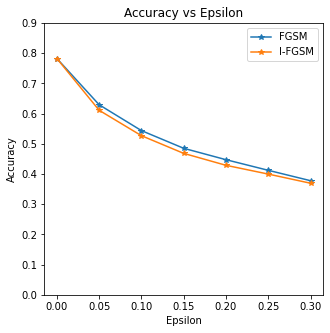

In [40]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies2, "*-")
plt.legend(['FGSM', 'I-FGSM'])
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Adversarial Samples at Each epsilon

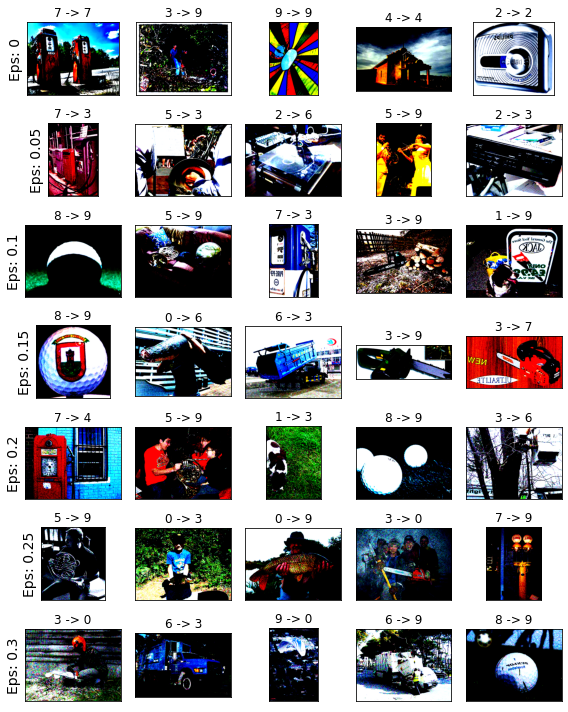

{0: 'tench', 1: 'english Springer', 2: 'cassette player', 3: 'chainsaw', 4: 'church', 5: 'French horn', 6: 'garbage truck', 7: 'gas pump', 8: 'golf ball', 9: 'parachute'}


In [41]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples2[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))

        tr = scipy.ndimage.rotate(ex.T, 270) # had to transpose to fit dimensions
        plt.imshow(make_grid(torch.tensor(tr), normalize=True))
plt.tight_layout()
plt.show()
print(label_map)

### Least Likely Class

In [42]:
def ll_attack(image, image_original, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image - epsilon*sign_data_grad # decrease
    # clipping
    delta = torch.clamp(perturbed_image - image_original, min=-epsilon, max=epsilon)
    perturbed_image = torch.clamp(image_original + delta, min=0, max=1).detach()
    return perturbed_image

In [43]:
def least_likely_test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    iters = int(min(epsilon + 4, 1.25 * epsilon)) # from paper, also alpha=1

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        i = torch.tensor(idxs).to(device)

        output = model(data)[:, i] # only select imagenette classes
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue
        
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        
        data_copy = data.clone().detach()
        perturbed_data = ll_attack(data, data_copy, epsilon, data_grad)
        for i in range(iters):
            output = model(perturbed_data)[:, i] # only select imagenette classes
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                break
            perturbed_data = ll_attack(data, data_copy, epsilon, data_grad)

        output = model(perturbed_data)[:, i] # only select imagenette classes
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [44]:
accuracies3 = []
examples3 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = least_likely_test(resnet, device, test_loader, eps)
    accuracies3.append(acc)
    examples3.append(ex)

Epsilon: 0	Test Accuracy = 3071 / 3925 = 0.782420382165605
Epsilon: 0.05	Test Accuracy = 3303 / 3925 = 0.8415286624203822
Epsilon: 0.1	Test Accuracy = 3214 / 3925 = 0.8188535031847134
Epsilon: 0.15	Test Accuracy = 3038 / 3925 = 0.7740127388535032
Epsilon: 0.2	Test Accuracy = 2883 / 3925 = 0.7345222929936306
Epsilon: 0.25	Test Accuracy = 2738 / 3925 = 0.6975796178343949
Epsilon: 0.3	Test Accuracy = 2592 / 3925 = 0.6603821656050956


### Visualizations

Plot of Accuracy vs Epsilon

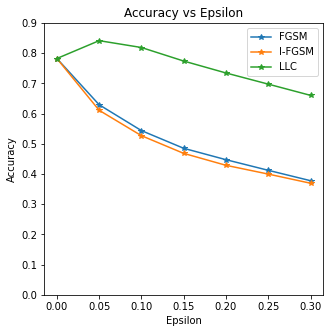

In [45]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies2, "*-")
plt.plot(epsilons, accuracies3, "*-")
plt.legend(['FGSM', 'I-FGSM', 'LLC'])
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Adversarial Samples at Each epsilon

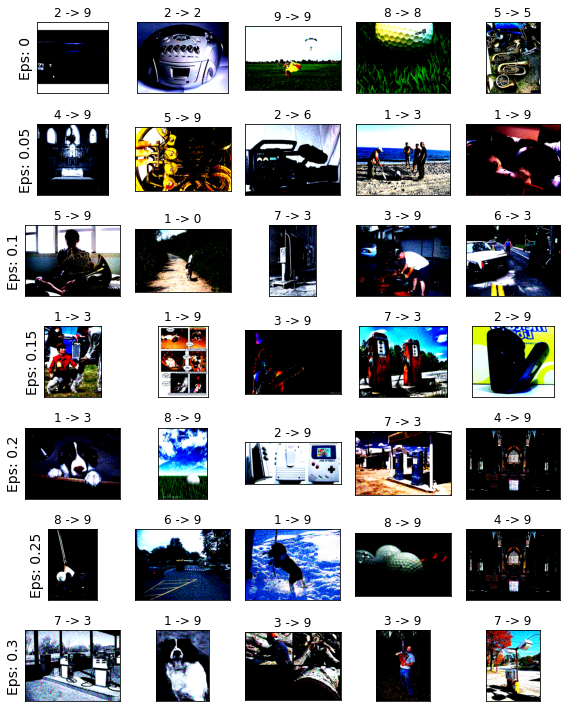

{0: 'tench', 1: 'english Springer', 2: 'cassette player', 3: 'chainsaw', 4: 'church', 5: 'French horn', 6: 'garbage truck', 7: 'gas pump', 8: 'golf ball', 9: 'parachute'}


In [46]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples3[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples3[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples3[i][j]
        plt.title("{} -> {}".format(orig, adv))

        tr = scipy.ndimage.rotate(ex.T, 270) # had to transpose to fit dimensions
        plt.imshow(make_grid(torch.tensor(tr), normalize=True))
plt.tight_layout()
plt.show()
print(label_map)